In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import datetime
import os

from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
from models.vae import DenseVariationalAutoencoder

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

TRAINING_FRACTION = 0.8
N_DENSE = 2
L=4
NON_LINEAR_ACTIVATION_BOOL=True

In [2]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
#DATA_NAME = 'digits'
DATA_NAME = 'xy'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [3]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"
    
tensorboard_log_dir = "{}/logs/fit/".format(prefix_s3) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [4]:
# Just do this so it is easier to configure arbitrary choices
work_with_t_list = [ "00.10", "00.20", "00.30",]# "00.40", "00.50", "00.60", "00.70", "00.80", "00.90", "01.00", "01.10", "01.20", "01.30", "01.40", "01.50", "01.60", "01.70", "01.80", "01.90", "02.00"]

In [5]:
df_bins = None
df_conf = None
for i, t_string in enumerate(work_with_t_list):
    bins_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/bins_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    configs_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/spinConfigs_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    if i == 0:
        df_bins = pd.read_csv(bins_f_name, sep="\t")
        df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
    else:
        cur_df_bins = pd.read_csv(bins_f_name, sep="\t")
        cur_df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
        df_bins = df_bins.append(cur_df_bins) 
        df_conf = df_conf.append(cur_df_conf) 
    print(bins_f_name)

/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.10-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.20-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.30-0000.txt


In [6]:
df_bins.shape

(30000, 10)

In [7]:
df_bins = df_bins.astype(
    {
        " T ": float,
        " binNum": int,
    }
)

In [8]:
df_conf["T"] = df_bins[" T "]

In [9]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [10]:
df_conf["M"] = mean_col

In [11]:
df_conf.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'T', 'M'], dtype='object')

In [12]:
df_conf.shape

(30000, 18)

In [13]:
df_conf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,T,M
0,0.162246,5.973095,6.133531,6.156717,0.025063,6.050038,6.020508,6.223365,0.067779,6.153401,6.032560,0.073008,6.134114,6.160847,0.052111,0.115091,0.1,4.606397
1,4.983357,4.822849,4.691446,4.885390,5.122919,4.853683,4.793827,4.921220,4.869675,5.132625,5.236716,4.908288,4.935758,4.859949,4.700985,5.001698,0.1,4.845760
2,2.727240,2.390374,2.708473,2.618912,2.354293,2.384652,2.535973,2.779869,2.592872,2.413333,2.715683,2.716086,2.763101,2.847251,2.660584,2.721994,0.1,2.611250
3,5.762936,5.839879,0.023180,6.216394,6.118754,6.144861,0.033664,0.032085,6.282960,0.085963,0.031738,0.152408,6.027732,6.234099,0.083261,0.023046,0.1,4.460597
4,4.463147,4.564015,4.342138,4.595675,4.269949,4.323170,4.407668,4.411044,4.368104,4.413393,4.490482,4.530060,4.503687,4.435605,4.239925,4.452277,0.1,4.491244


In [14]:
cols = []
for i in range(L*L):
    cols.append(str(i))
    cols.append(str(i))
print(cols)

['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', '10', '10', '11', '11', '12', '12', '13', '13', '14', '14', '15', '15']


In [15]:
xy_spec = ["x", "y"] * L*L

In [16]:
for i in zip(cols, xy_spec):
    continue
    #print(i)

In [17]:
np_angle_matrix = df_conf.drop(["T","M"], axis=1).to_numpy()

In [18]:
np_x_matrix = np.cos(np_angle_matrix)
np_y_matrix = np.sin(np_angle_matrix)

In [19]:
#np.concatenate(np_x_matrix, np_x_matrix, axis=1)
df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(zip(cols, xy_spec)))

In [20]:
df.sort_index(ascending=True, inplace=True, axis=1)

In [21]:
df.loc[:, (slice(None), slice("x"))] = np_x_matrix

In [22]:
np_x_matrix

array([[ 0.986867  ,  0.9523061 ,  0.98882268, ...,  0.99252601,
         0.99864253,  0.99338439],
       [ 0.26766423,  0.11023518, -0.0209416 , ...,  0.14702497,
        -0.01140408,  0.28528988],
       [-0.91537707, -0.73085744, -0.90766075, ..., -0.95699346,
        -0.88652882, -0.91325267],
       ...,
       [-0.99996531, -0.78798196, -0.81200276, ..., -0.93132133,
        -0.97910067, -0.96902602],
       [ 0.73166437,  0.99926935,  0.68109528, ...,  0.951746  ,
         0.93244177,  0.90483846],
       [-0.35623912, -0.17665983, -0.22011722, ...,  0.07685637,
         0.24162666,  0.04673386]])

In [23]:
np_y_matrix

array([[ 0.16153491, -0.30514438, -0.14909632, ..., -0.12203327,
         0.05208737,  0.11483667],
       [-0.96351225, -0.99390553, -0.9997807 , ..., -0.98913278,
        -0.99993497, -0.95844128],
       [ 0.40259759,  0.68253015,  0.41970462, ...,  0.29010949,
         0.46267338,  0.40739362],
       ...,
       [ 0.00832939, -0.61569833, -0.5836536 , ..., -0.36419854,
         0.20337621,  0.24695866],
       [-0.68166506, -0.03821998, -0.7321948 , ..., -0.30688686,
        -0.36132028, -0.42575505],
       [ 0.93439482,  0.98427197,  0.97547343, ...,  0.99704218,
         0.97036929,  0.99890738]])

In [24]:
df.loc[:, (slice(None), "y")] = np_y_matrix

In [25]:
df

0                   1                  10                  11  \
              x         y         x         y         x         y         x   
0      0.986867  0.161535  0.952306 -0.305144  0.988823 -0.149096  0.992013   
1      0.267664 -0.963512  0.110235 -0.993906 -0.020942 -0.999781  0.172139   
2     -0.915377  0.402598 -0.730857  0.682530 -0.907661  0.419705 -0.866484   
3      0.867695 -0.497097  0.903339 -0.428928  0.999731  0.023177  0.997770   
4     -0.246669 -0.969100 -0.147830 -0.989013 -0.361850 -0.932236 -0.116449   
...         ...       ...       ...       ...       ...       ...       ...   
29995  0.246862 -0.969051  0.309302 -0.950964 -0.078424 -0.996920  0.407209   
29996 -0.610500 -0.792016 -0.715634 -0.698475 -0.613806 -0.789457 -0.639160   
29997 -0.999965  0.008329 -0.787982 -0.615698 -0.812003 -0.583654 -0.976266   
29998  0.731664 -0.681665  0.999269 -0.038220  0.681095 -0.732195  0.549889   
29999 -0.356239  0.934395 -0.176660  0.984272 -0.220117  0.975473 -0.372997   

                       12            ...         5                   6  \
              y         x         y  ...         x         y         x   
0     -0.126132  0.999686  0.025061  ...  0.997336  0.072943  0.988909   
1     -0.985073  0.399095 -0.916909  ...  0.194648 -0.980873  0.221516   
2      0.499204 -0.705761  0.708450  ... -0.910830  0.412782 -0.929223   
3     -0.066742  0.986512 -0.163692  ...  0.988408  0.151819  0.967549   
4     -0.993197 -0.428146 -0.903710  ... -0.181321 -0.983424 -0.207191   
...         ...       ...       ...  ...       ...       ...       ...   
29995 -0.913335  0.419934 -0.907555  ...  0.273856 -0.961771 -0.245455   
29996 -0.769074 -0.667019 -0.745041  ... -0.713515 -0.700640 -0.744314   
29997 -0.216573 -0.989320  0.145759  ... -0.989930 -0.141555 -0.950693   
29998 -0.835238  0.781016 -0.624511  ...  0.851688 -0.524048  0.481699   
29999  0.927833 -0.633948  0.773376  ...  0.431784  0.901977 -0.301467   

                        7                   8                   9            
              y         x         y         x         y         x         y  
0     -0.148520  0.992526 -0.122033  0.998643  0.052087  0.993384  0.114837  
1     -0.975157  0.147025 -0.989133 -0.011404 -0.999935  0.285290 -0.958441  
2      0.369519 -0.956993  0.290109 -0.886529  0.462673 -0.913253  0.407394  
3     -0.252684  0.998796 -0.049066  0.996536  0.083165  0.999734  0.023044  
4     -0.978301 -0.273263 -0.961939 -0.455082 -0.890450 -0.257189 -0.966361  
...         ...       ...       ...       ...       ...       ...       ...  
29995 -0.969408  0.360687 -0.932687  0.298391 -0.954444 -0.276970 -0.960878  
29996 -0.667830 -0.811583 -0.584237 -0.449800 -0.893129 -0.445553 -0.895256  
29997  0.310133 -0.931321 -0.364199 -0.979101  0.203376 -0.969026  0.246959  
29998 -0.876337  0.951746 -0.306887  0.932442 -0.361320  0.904838 -0.425755  
29999  0.953477  0.076856  0.997042  0.241627  0.970369  0.046734  0.998907  

[30000 rows x 32 columns]

In [26]:
train_with_meta_info = df.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = df.drop(index=train_with_meta_info.index)
#train = train_with_meta_info.drop(["T","M"], axis=1)
#test = test_with_meta_info.drop(["T","M"], axis=1)
train = train_with_meta_info
test = test_with_meta_info

In [27]:
img_pca = PCA(n_components=N_DENSE)
img_pca.fit(train.to_numpy())

PCA(n_components=2)

In [28]:
components = img_pca.transform(df.to_numpy())

In [29]:
df.to_numpy().shape

(30000, 32)

In [30]:
components.shape

(30000, 2)

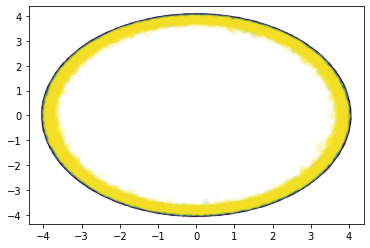

In [31]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["T"]), alpha=0.1)

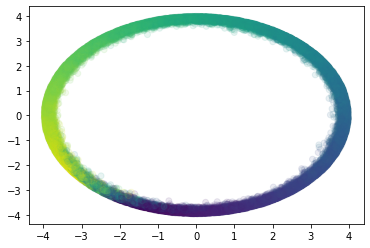

In [32]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["M"]), alpha=0.1)

# Dense AE

In [33]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L*L*2,)),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(L*L*2),
    ]
)

print(simp_ae.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_space (Dense)        (None, 2)                 64        
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None


2022-08-26 09:01:02.638794: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-26 09:01:02.638820: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: owen-PRIME-Z390-A
2022-08-26 09:01:02.638825: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: owen-PRIME-Z390-A
2022-08-26 09:01:02.638897: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-08-26 09:01:02.638914: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-08-26 09:01:02.638918: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-08-26 09:01:02.639383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

In [34]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=0,  
    write_graph=True,
    write_images=True
)

simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [35]:
simp_ae.fit(
    batch_size=16,
    x=train.to_numpy(),
    y=train.to_numpy(),
    epochs=20,
    callbacks=[tb_callback]
)

Epoch 1/20
1500/1500 [==============================] - 1s 639us/step - loss: 0.1184 - mae: 0.2307
Epoch 2/20
1500/1500 [==============================] - 1s 901us/step - loss: 0.0286 - mae: 0.1222
Epoch 3/20
1500/1500 [==============================] - 1s 995us/step - loss: 0.0279 - mae: 0.1197
Epoch 4/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0277 - mae: 0.1192
Epoch 5/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0277 - mae: 0.1191
Epoch 6/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0277 - mae: 0.1191
Epoch 7/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0277 - mae: 0.1191
Epoch 8/20
1500/1500 [==============================] - 1s 804us/step - loss: 0.0277 - mae: 0.1191
Epoch 9/20
1500/1500 [==============================] - 1s 777us/step - loss: 0.0277 - mae: 0.1191
Epoch 10/20
1500/1500 [==============================] - 1s 966us/step - loss: 0.0277 - mae: 0.1191
Epoch 11/20
1500/

In [36]:
mid_layer = simp_ae.get_layer('latent_space')

In [37]:
mid_layer.get_weights()[0].shape

(32, 2)

In [38]:
extractor = keras.Model(inputs=simp_ae.inputs,
                        outputs=[layer.output for layer in simp_ae.layers])

In [39]:
features = extractor(df.to_numpy())

In [40]:
features[0].numpy()

array([[ 1.4963596 , -2.4167662 ],
       [-1.9933106 , -2.1420643 ],
       [-0.28064847,  2.8276598 ],
       ...,
       [-1.756949  ,  2.102051  ],
       [ 0.46402752, -2.6977084 ],
       [ 2.0313    ,  1.9711423 ]], dtype=float32)

In [41]:
features[0][:,0]

<tf.Tensor: shape=(30000,), dtype=float32, numpy=
array([ 1.4963596 , -1.9933106 , -0.28064847, ..., -1.756949  ,
        0.46402752,  2.0313    ], dtype=float32)>

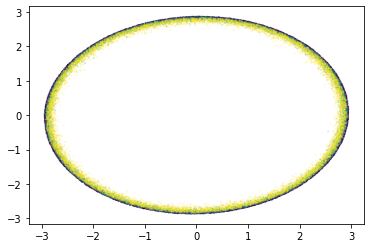

In [42]:
plt.scatter(features[0][:,0], features[0][:,1], c=df_conf["T"], s=0.5, alpha=0.2)

# Dense VAE

In [60]:
x = train.to_numpy().reshape(-1,L*L*2)
x_test = test.to_numpy().reshape(-1,L*L*2)
x = x.astype(float)
x_test = x_test.astype(float)

In [61]:
print(x.shape)
print(x_test.shape)

(24000, 32)
(6000, 32)


In [62]:
print(type(x))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [63]:
#x = x+10
#x_test = x_test+10

In [65]:
vae = DenseVariationalAutoencoder(
    input_dim=(L*L*2,),
    encoder_layer_sizes=[2],
    decoder_layer_sizes=[2, L*L*2],
    z_dim=N_DENSE,
    non_linear_activation_bool=NON_LINEAR_ACTIVATION_BOOL
)

In [66]:
LEARNING_RATE = 0.0005
#R_LOSS_FACTOR = 1000
R_LOSS_FACTOR = 1000

In [67]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [68]:
BATCH_SIZE = 16
EPOCHS = 5
PRINT_EVERY_N_BATCHES = 10
INITIAL_EPOCH = 0

In [69]:
r = vae.train(     
    x,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = INITIAL_EPOCH,
    x_test=tf.data.Dataset.from_tensor_slices(x_test)
)

Epoch 1/5


TypeError: in user code:

    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 449, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/keras_tensor.py", line 254, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_11'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.
